# Tu Compra En Casa

Eddy Tovar

Task: Análisis preliminar

Importing necesary libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [2]:
# Leyendo csv principal
dtype_dict = {"user_postal_code": str, "shop_postal_code": str} # Tratar al codigo postal como string
df = pd.read_csv('data/Challenge example.csv', sep='\t', dtype=dtype_dict)
df.head()

,request_delivered_at,delivered_at,city,user_postal_code,shop_postal_code,market,order_status,device_method,service_type,user_id,user_first_order,shopper_id,shopper_rol,delivery_price,product_price,num_products_requested,num_products_delivered
0,2019-12-26 11:00:00,2019-12-26 11:07:53,Albacete,02007,02032,mercado1,delivered,iphone,express,1574287,2019-07-20,1870,ROLE_SUPER_USER,531,2382,8,8
1,2019-10-03 11:00:00,2019-10-03 11:56:05,Albacete,02222,02028,mercado3,delivered,desktop,express,1466085,2019-05-09,1211,ROLE_USER,604,2247,11,11
2,2019-07-26 12:00:00,2019-07-26 12:47:21,Albacete,02043,02031,mercado1,delivered,android,express,744052,2016-11-24,1324,ROLE_USER,364,3165,21,21
3,2019-02-14 20:00:00,2019-02-14 19:53:43,Albacete,02003,02017,mercado1,delivered,android,express,1074463,2018-09-19,633,ROLE_USER,215,6810,32,32
4,2019-09-03 19:00:00,NaN,Albacete,02013,02906,mercado1,canceled,iphone,express,607479,2016-10-14,846,ROLE_SUPER_USER,372,0,21,21


# Limpieza de datos
Primero que todo, debemos entender los datos, analizarlos y prepararlos correctamente para luego poder extraer la información.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37169 entries, 0 to 37168
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   request_delivered_at    37169 non-null  object
 1   delivered_at            36480 non-null  object
 2   city                    37169 non-null  object
 3   user_postal_code        37169 non-null  object
 4   shop_postal_code        37113 non-null  object
 5   market                  37169 non-null  object
 6   order_status            37169 non-null  object
 7   device_method           36997 non-null  object
 8   service_type            37169 non-null  object
 9   user_id                 37169 non-null  int64 
 10  user_first_order        37122 non-null  object
 11  shopper_id              37169 non-null  int64 
 12  shopper_rol             37169 non-null  object
 13  delivery_price          37169 non-null  int64 
 14  product_price           37169 non-null  int64 
 15  nu

In [4]:
# Check missing values for each column
df.isna().sum().sort_values(ascending=False)

delivered_at              689
device_method             172
shop_postal_code           56
user_first_order           47
num_products_delivered      0
city                        0
user_postal_code            0
market                      0
order_status                0
service_type                0
num_products_requested      0
user_id                     0
shopper_id                  0
shopper_rol                 0
delivery_price              0
product_price               0
request_delivered_at        0
dtype: int64

#### Hay algunos valores nulos que debemos tener en cuenta
- fecha de entrega (delivered_at), aquí los valores nulos pueden referirse a cancelaciones.

In [5]:
df.describe().round(2)

,user_id,shopper_id,delivery_price,product_price,num_products_requested,num_products_delivered
count,37169.00,37169.00,37169.00,37169.00,37169.00,37169.00
mean,1036879.24,975.18,485.45,7353.84,26.58,26.58
std,437777.42,412.83,177.36,5818.86,16.50,16.50
min,3.00,3.00,0.00,-11219.00,-1.00,-1.00
25%,728535.00,801.00,359.00,3538.00,15.00,15.00
50%,1008021.00,861.00,486.00,5883.00,24.00,24.00
75%,1414047.00,1218.00,616.00,9450.00,35.00,35.00
max,2657739.00,1979.00,2463.00,90200.00,158.00,158.00


#### Otros problemas:
- precios de productos negativos
- número de productos negativos
- número de productos = 0 (pueden ser cancelaciones)

In [6]:
df['shopper_rol'].value_counts()

ROLE_USER           24905
ROLE_SUPER_USER     11403
ROLE_DRIVER           782
ROLE_TEST              56
ROLE_SUPER_ADMIN       20
ROLE_ADMIN              3
Name: shopper_rol, dtype: int64

- Debemos quitar los pedidos que no sean de usuarios para evitar outliers o valores introducidos para testing.
- También quitaremos los valores negativos
- Crearemos una columna para el precio total en euros

In [7]:
#quitar valores negativos
shop_df = df[df['product_price'] >= 0]
shop_df = shop_df[shop_df['num_products_requested'] >= 0]

#dejar solo usuarios
shop_df = shop_df.loc[(shop_df['shopper_rol'] == 'ROLE_USER') | (shop_df['shopper_rol'] == 'ROLE_SUPER_USER')]

#quitar columnas innecesarias
shop_df.drop(['city'], axis=1, inplace=True)

#crear columna de precio total en euros
shop_df['total_price'] = (shop_df['delivery_price'] + shop_df['product_price'])/100

In [8]:
shop_df.head()

,request_delivered_at,delivered_at,user_postal_code,shop_postal_code,market,order_status,device_method,service_type,user_id,user_first_order,shopper_id,shopper_rol,delivery_price,product_price,num_products_requested,num_products_delivered,total_price
0,2019-12-26 11:00:00,2019-12-26 11:07:53,02007,02032,mercado1,delivered,iphone,express,1574287,2019-07-20,1870,ROLE_SUPER_USER,531,2382,8,8,29.13
1,2019-10-03 11:00:00,2019-10-03 11:56:05,02222,02028,mercado3,delivered,desktop,express,1466085,2019-05-09,1211,ROLE_USER,604,2247,11,11,28.51
2,2019-07-26 12:00:00,2019-07-26 12:47:21,02043,02031,mercado1,delivered,android,express,744052,2016-11-24,1324,ROLE_USER,364,3165,21,21,35.29
3,2019-02-14 20:00:00,2019-02-14 19:53:43,02003,02017,mercado1,delivered,android,express,1074463,2018-09-19,633,ROLE_USER,215,6810,32,32,70.25
4,2019-09-03 19:00:00,NaN,02013,02906,mercado1,canceled,iphone,express,607479,2016-10-14,846,ROLE_SUPER_USER,372,0,21,21,3.72


In [9]:
shop_df.isna().sum().sort_values(ascending=False)

delivered_at              634
device_method             111
user_first_order           44
total_price                 0
service_type                0
user_postal_code            0
shop_postal_code            0
market                      0
order_status                0
user_id                     0
num_products_delivered      0
shopper_id                  0
shopper_rol                 0
delivery_price              0
product_price               0
num_products_requested      0
request_delivered_at        0
dtype: int64

Nos damos cuentas que solo quedan 3 columnas con valores vacíos que no serían tan importante a la hora de sacar conclusiones en los datos.

In [10]:
shop_df[shop_df['num_products_requested'] == 0].head()

,request_delivered_at,delivered_at,user_postal_code,shop_postal_code,market,order_status,device_method,service_type,user_id,user_first_order,shopper_id,shopper_rol,delivery_price,product_price,num_products_requested,num_products_delivered,total_price
521,2019-11-14 10:00:00,NaN,02034,02039,mercado7,canceled,android,ahorro,1751294,2019-11-20,402,ROLE_SUPER_USER,707,0,0,0,7.07
1084,2019-05-30 18:00:00,NaN,02019,02011,mercado1,canceled,iphone,express,1456182,2019-05-30,771,ROLE_USER,373,0,0,0,3.73
2095,2019-11-15 17:00:00,NaN,02025,02029,mercado3,canceled,desktop,express,1729855,2019-11-15,1851,ROLE_USER,378,0,0,0,3.78
6645,2019-11-19 18:00:00,NaN,02005,02030,mercado3,canceled,desktop,express,1786655,2019-11-19,1269,ROLE_USER,2463,0,0,0,24.63
8852,2019-11-19 19:00:00,NaN,02010,02224,mercado3,canceled,desktop,express,788142,2018-02-07,1876,ROLE_USER,400,0,0,0,4.00


Al analizar los pedidos con 0 productos, entendemos que se refieren a productos cancelados.

In [11]:
shop_df.order_status.value_counts()

delivered         35662
canceled            639
assigned              3
waiting_driver        1
Name: order_status, dtype: int64

Nos quedaremos solamente con los pedidos entregados y cancelados

In [12]:
shop_df = shop_df[(shop_df['order_status'] == 'canceled') | (shop_df['order_status'] == 'delivered')]
shop_df

,request_delivered_at,delivered_at,user_postal_code,shop_postal_code,market,order_status,device_method,service_type,user_id,user_first_order,shopper_id,shopper_rol,delivery_price,product_price,num_products_requested,num_products_delivered,total_price
0,2019-12-26 11:00:00,2019-12-26 11:07:53,02007,02032,mercado1,delivered,iphone,express,1574287,2019-07-20,1870,ROLE_SUPER_USER,531,2382,8,8,29.13
1,2019-10-03 11:00:00,2019-10-03 11:56:05,02222,02028,mercado3,delivered,desktop,express,1466085,2019-05-09,1211,ROLE_USER,604,2247,11,11,28.51
2,2019-07-26 12:00:00,2019-07-26 12:47:21,02043,02031,mercado1,delivered,android,express,744052,2016-11-24,1324,ROLE_USER,364,3165,21,21,35.29
3,2019-02-14 20:00:00,2019-02-14 19:53:43,02003,02017,mercado1,delivered,android,express,1074463,2018-09-19,633,ROLE_USER,215,6810,32,32,70.25
4,2019-09-03 19:00:00,NaN,02013,02906,mercado1,canceled,iphone,express,607479,2016-10-14,846,ROLE_SUPER_USER,372,0,21,21,3.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37163,2019-09-27 14:00:00,2019-09-27 15:09:14,02043,02801,mercado1,delivered,iphone,express,1376886,2019-03-08,1055,ROLE_SUPER_USER,618,9449,42,42,100.67
37164,2019-06-03 12:00:00,2019-06-03 12:01:43,02016,02221,mercado1,delivered,iphone,express,892045,2018-05-03,859,ROLE_SUPER_USER,459,8340,14,14,87.99
37166,2019-07-12 18:00:00,2019-07-12 19:07:27,02028,02012,mercado1,delivered,android,express,747549,2017-07-11,1359,ROLE_USER,604,1713,13,13,23.17
37167,2019-11-29 10:00:00,2019-11-29 10:53:39,02036,02046,mercado1,delivered,iphone,express,714627,2016-09-28,1590,ROLE_USER,666,6967,39,39,76.33


In [13]:
# cambiar los formatos de string a fecha para poder trabajar con ellas
shop_df['request_delivered_at'] = pd.to_datetime(shop_df['request_delivered_at'], format='%Y-%m-%d %H:%M:%S')
shop_df['delivered_at'] = pd.to_datetime(shop_df['delivered_at'], format='%Y-%m-%d %H:%M:%S')
shop_df['user_first_order'] = pd.to_datetime(shop_df['user_first_order'], format='%Y-%m-%d')

In [14]:
#quitar fechas incorrectas en delivered_at y los valores nulos que no sean de cancelaciones
start = dt.datetime(year=2019, month=1, day=1)
end = dt.datetime(year=2019, month=12, day=31)

shop_df = shop_df[(
    (shop_df['delivered_at'] > start) & (shop_df['delivered_at'] < end) 
    | (shop_df['delivered_at'].isna())
    )]

# Análisis

In [15]:
shop_df.describe()

,user_id,shopper_id,delivery_price,product_price,num_products_requested,num_products_delivered,total_price
count,3.626400e+04,36264.000000,36264.000000,36264.000000,36264.000000,36264.000000,36264.000000
mean,1.037062e+06,981.842488,484.772750,7389.519386,26.697910,26.697910,78.742921
std,4.358121e+05,408.797147,177.346907,5817.597565,16.535468,16.535468,58.045548
min,3.000000e+00,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.285570e+05,819.000000,358.000000,3562.000000,15.000000,15.000000,40.700000
50%,1.004680e+06,867.000000,485.000000,5911.000000,24.000000,24.000000,63.950000
75%,1.411488e+06,1221.000000,616.000000,9493.000000,35.000000,35.000000,99.595000
max,2.657739e+06,1979.000000,2463.000000,90200.000000,158.000000,158.000000,907.880000


Todo listo...
- No tenemos valores negativos
- Sabemos que los valores en 0 se refieren a los productos cancelados
- a media gastada en compras es de 78,7 euros. Tiket medio de compra

# ¿Cuantos? (shoppers, users, ...)

In [16]:
print('Total de shoppers {}'.format(shop_df['shopper_id'].nunique()))
print('Total de usuarios {}'.format(shop_df['user_id'].nunique()))
print('Total de mercados {}'.format(shop_df['market'].nunique()))
print('Total de codigos postales {}'.format(shop_df['user_postal_code'].nunique()))
print('Total de codigos postales {}'.format(shop_df['shop_postal_code'].nunique()))
print('Total de pedidos {}'.format(shop_df.shape[0]))

Total de shoppers 609
Total de usuarios 11598
Total de mercados 7
Total de codigos postales 73
Total de codigos postales 132
Total de pedidos 36264


### Escritorio vs móviles

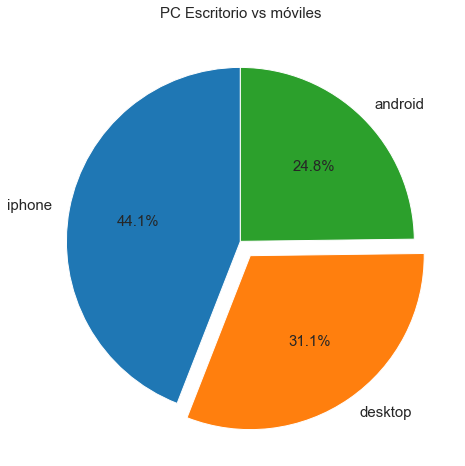

In [17]:
devices = (shop_df['device_method'].value_counts()/shop_df.shape[0] * 100).round(1)
ax = devices.plot(
    kind = 'pie',
    fontsize = 15,
    figsize = (8, 8),
    explode = (0, 0.1, 0),
    autopct = '%1.1f%%',
    startangle = 90
)
ax.set_xlabel(xlabel='')
ax.set_ylabel(ylabel='')
ax.set_title('PC Escritorio vs móviles', fontsize=15)
ax.xaxis.grid()

plt.show()

Podemos observar fácilmente que los usuarios utilizan mucho más los móviles para realizar las compras.  
Siendo Iphone el medio más usado. 

Filtremos solo los pedidos entregados.

In [18]:
delv_df = shop_df[shop_df['order_status'] == 'delivered']
delv_df.head(5)

,request_delivered_at,delivered_at,user_postal_code,shop_postal_code,market,order_status,device_method,service_type,user_id,user_first_order,shopper_id,shopper_rol,delivery_price,product_price,num_products_requested,num_products_delivered,total_price
0,2019-12-26 11:00:00,2019-12-26 11:07:53,02007,02032,mercado1,delivered,iphone,express,1574287,2019-07-20,1870,ROLE_SUPER_USER,531,2382,8,8,29.13
1,2019-10-03 11:00:00,2019-10-03 11:56:05,02222,02028,mercado3,delivered,desktop,express,1466085,2019-05-09,1211,ROLE_USER,604,2247,11,11,28.51
2,2019-07-26 12:00:00,2019-07-26 12:47:21,02043,02031,mercado1,delivered,android,express,744052,2016-11-24,1324,ROLE_USER,364,3165,21,21,35.29
3,2019-02-14 20:00:00,2019-02-14 19:53:43,02003,02017,mercado1,delivered,android,express,1074463,2018-09-19,633,ROLE_USER,215,6810,32,32,70.25
5,2019-07-02 19:00:00,2019-07-02 19:24:40,02014,02702,mercado1,delivered,desktop,express,709090,2017-11-06,856,ROLE_SUPER_USER,356,6166,17,17,65.22


In [19]:
# Ingresos Totales
delv_df['total_price'].sum().round(0)

2852158.0

Veamos los nuevos usuarios contra los recurrentes

In [20]:
news = (delv_df['user_id'].value_counts() == 1).sum()
recurrent = (delv_df['user_id'].value_counts() > 1).sum()
news_prc = ((news/delv_df['user_id'].nunique())*100).round(0)
recurrent_prc = ((recurrent/delv_df['user_id'].nunique())*100).round(0)
print('news {} {}%'.format(news, news_prc))
print('news {} {}%'.format(recurrent, recurrent_prc))

news 5825 51.0%
news 5618 49.0%


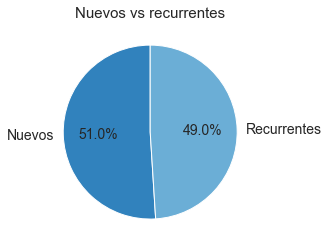

In [21]:
cmap = plt.get_cmap("tab20c")
plt.pie(
    x=(news_prc, recurrent_prc),
    autopct = '%1.1f%%',
    startangle = 90,
    labels=['Nuevos', 'Recurrentes'],
    textprops={'fontsize': 14},
    colors=cmap(np.arange(5)),
)
plt.title('Nuevos vs recurrentes', fontsize=15)
plt.show()

# ¿Cuando? (compras, precio, coste, entrega a tiempo, ...)

### Evolutivo

In [22]:
# Cantidad de usuarios únicos mensuales
uniq_users = shop_df.groupby(shop_df['request_delivered_at'].dt.month)['user_id'].nunique()
uniq_users

request_delivered_at
1     2116
2     1968
3     2363
4     2135
5     2465
6     2437
7     2111
8     1569
9     2569
10    2550
11    2730
12    1956
Name: user_id, dtype: int64

In [23]:
total_month = delv_df.set_index('request_delivered_at').resample('M').count()['product_price']

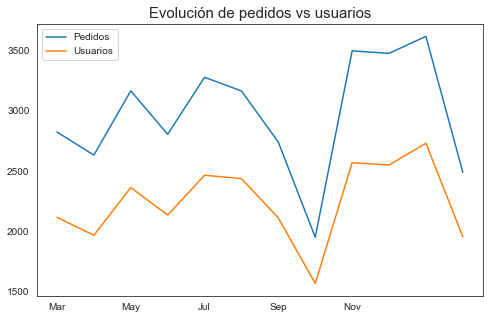

In [24]:
evol = pd.DataFrame({'Pedidos': total_month.tolist(), 'Usuarios': uniq_users.to_list()})
ax = evol.plot(
    figsize = (8,5),
)

ax.set_xticklabels(['Ene', 'Mar', 'May', 'Jul', 'Sep', 'Nov'])
ax.set_title('Evolución de pedidos vs usuarios', fontsize=15)

plt.show()

Esta gráfica muestra que se ha mantenido la recorrencia de los usuarios durante el año.

In [25]:
#Obtendremos la cantidad de usuarios antes de 2019
shop_df.set_index('user_first_order').resample('M')['request_delivered_at'].count()
user_first = shop_df.groupby('user_id')['user_first_order'].min()
users_before = (user_first < dt.datetime(day=1, month=1, year=2019)).sum()
users_before

4668

In [26]:
#Obtenemos solo los usuarios de 2019
user_year = user_first[(user_first >= start) & (user_first <= end)]
user_year

user_id
11886     2019-07-13
16153     2019-01-18
23126     2019-02-19
45887     2019-02-01
46190     2019-06-14
             ...    
1843971   2019-12-28
1844118   2019-12-30
1845100   2019-12-30
1845629   2019-12-30
1845795   2019-12-30
Name: user_first_order, Length: 6843, dtype: datetime64[ns]

In [27]:
month_users = user_year.to_frame().reset_index().set_index('user_first_order').resample('M').count()
month_users

,user_id
user_first_order,
2019-01-31,460
2019-02-28,467
2019-03-31,602
2019-04-30,603
2019-05-31,766
2019-06-30,756
2019-07-31,531
2019-08-31,410
2019-09-30,662


### Pedidos Mensuales

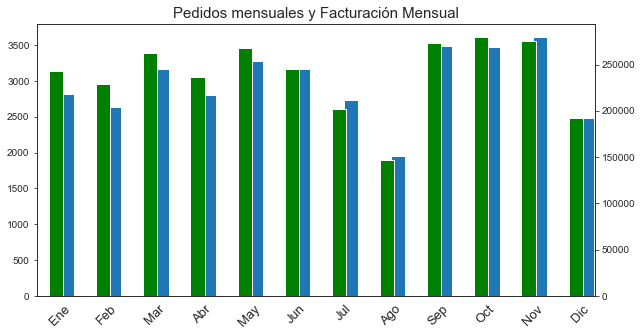

In [28]:
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

delv_df.set_index('request_delivered_at').resample('M').count()['product_price'].plot(
    kind ='bar',
    ax = ax_left,
    position = 0, 
    width = 0.3,
    figsize = (10,5)
)
delv_df.set_index('request_delivered_at').resample('M')['total_price'].sum().plot(
    kind='bar',
    ax = ax_right,
    position = 0.8,
    width = 0.3,
    color = 'Green',
)

ax_left.set_title('Pedidos mensuales y Facturación Mensual',fontsize=15)
ax_left.set_xticklabels(
    labels = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], 
    rotation = 45,
    fontsize = 13
    )
ax_left.set_xlabel('')
plt.show()

- Excluyendo diciembre, los últimos meses del año son los más prolíficos, mientras el verano es el peor período.
- Solo agosto y diciembre están por debajo de 200 000 euros

### Promedio de ventas por dia de la semana

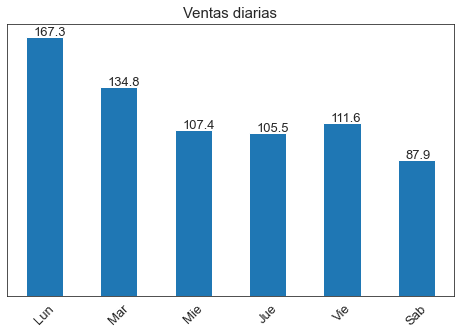

In [29]:
#Creando un nuevo data frame para incluir los días de la semana
daily_df = delv_df.copy()
daily_df['dayofweek'] = delv_df['request_delivered_at'].dt.dayofweek.to_frame()

# Primero agrupamos por día y luego por día de la semana
daily_df = daily_df.set_index('request_delivered_at').resample('D').agg(
    {'total_price': 'count', 'dayofweek': min}
    ).groupby('dayofweek')['total_price'].mean().round(1)

ax = daily_df.plot(
    kind='bar',
    figsize = (8,5)
)
ax.set_xlabel('',fontsize=15)
ax.set_ylabel('',fontsize=15)
ax.set_title('Ventas diarias',fontsize=15)
ax.set_xticklabels(
    labels = ['Lun', 'Mar', 'Mie', 'Jue', 'Vie', 'Sab'], 
    rotation = 45, 
    fontsize=13
    )
ax.set_yticklabels('')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()  + 0.1, p.get_height() * 1.005), size=13)

- Claramente los lunes son los días de mejores ventas, superando los 12 000 euros
- Por otra parte, los sábados son los días mas flojos

#### Ventas por hora

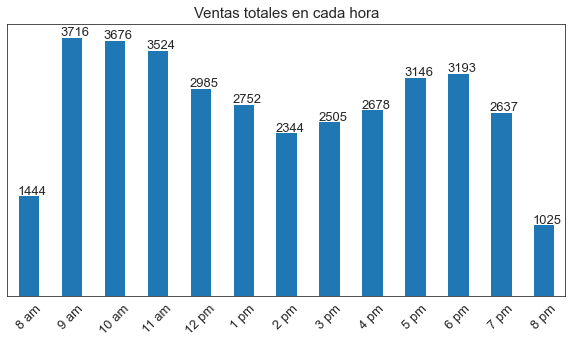

In [30]:
ax = delv_df.groupby(delv_df['request_delivered_at'].dt.hour)['total_price'].count().sort_index().plot(
    kind='bar',
    figsize = (10,5)
)
ax.set_xlabel('',fontsize=15)
ax.set_ylabel('',fontsize=15)
ax.set_title('Ventas totales en cada hora',fontsize=15)

#formato hora
x_ticks = [str(x)+' am' for x in range(8,12)] + ['12 pm'] + [str(x)+' pm' for x in range(1,9)]

ax.set_xticklabels(x_ticks, rotation='45', fontsize=13)
ax.set_yticklabels('')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.005), size=13)
plt.show()

Si miramos los horarios, nos damos cuentas que en las primeras horas de la mañana es cuando hay más actividad.  
Luego al medio día hay un descenso que vuelve a aumentar al final de la tarde.

# ¿Qué? (ahorro/express, mercado, ...)

### Calculemos el tiempo promedio de entrega de los pedidos.

In [33]:
# creamos una columna para calcular el tiempo de entrega
delv_df['delivered_time'] = delv_df['delivered_at'] - delv_df['request_delivered_at']

# eliminaremos los tiempos de entrega negativos
pdelv_df = delv_df[delv_df['delivered_time'] > dt.timedelta(0)]

In [34]:
(delv_df['delivered_time'] > dt.timedelta(days=1)).sum()

40

Solo 40 pedidos fueron entregados luego de 1 día. Considerémoslo outliers. 

In [35]:
# Eliminando pedidos de más de 24h
pdelv_df = pdelv_df[pdelv_df['delivered_time'] < dt.timedelta(days=1)]

In [36]:
express = pdelv_df[pdelv_df['service_type'] == 'express']
ahorro = pdelv_df[pdelv_df['service_type'] == 'ahorro']

print("servicio express {}".format(express['delivered_time'].mean()))
print("servicio ahorro  {}".format(ahorro['delivered_time'].mean()))

servicio express 0 days 00:50:10.173501
servicio ahorro  0 days 01:48:01.802455


In [37]:
express_gain = pdelv_df[pdelv_df['service_type'] == 'express']['total_price'].sum()
ahorro_gain = pdelv_df[pdelv_df['service_type'] == 'ahorro']['total_price'].sum()

print("servicio express {}".format(express_gain))
print("servicio ahorro  {}".format(ahorro_gain))

servicio express 2474075.84
servicio ahorro  173957.02000000002


- Obtenemos un promedio de entrega de 50 min  
- Para el servicio express y de 1 hora y 48 min para el servicio de ahorro

In [38]:
#Crear columna con tiempo de entrega en segundos
express['delivered_min'] = express['delivered_time'].dt.seconds
ahorro['delivered_min'] = ahorro['delivered_time'].dt.seconds

In [39]:
express_mean = express.groupby(express['request_delivered_at'].dt.month)['delivered_min'].mean()/60
ahorro_mean = ahorro.groupby(ahorro['request_delivered_at'].dt.month)['delivered_min'].mean()/60

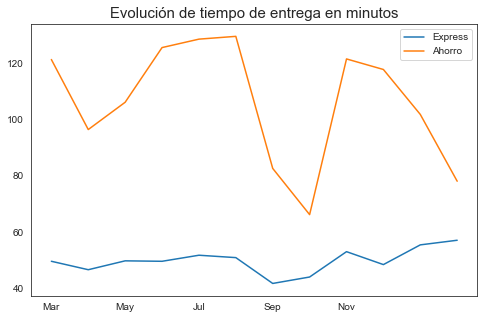

In [40]:
exp_aho = pd.DataFrame({'Express': express_mean.tolist(), 'Ahorro': ahorro_mean.tolist()})
ax = exp_aho.plot(
    figsize = (8,5),
)

ax.set_xticklabels(['Ene', 'Mar', 'May', 'Jul', 'Sep', 'Nov'])
ax.set_title('Evolución de tiempo de entrega en minutos', fontsize=15)

plt.show()

### Veamos las ventas y cancelaciones por Mercados. 

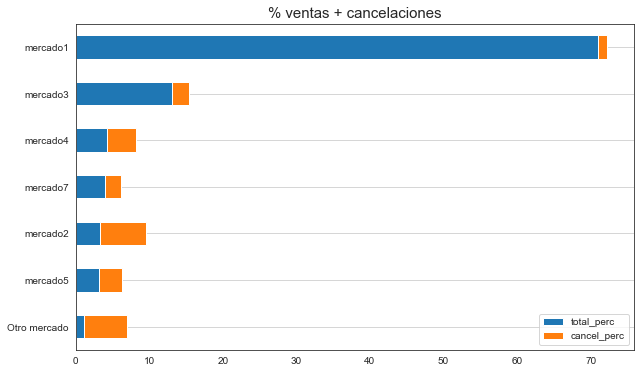

In [41]:
#Total de pedidos por mercados
market_df = pd.DataFrame()
market_df['total'] = shop_df['market'].value_counts().sort_index()

#Total de cancelaciones por mercado
market_df['canceled'] = shop_df['market'][shop_df['order_status'] == 'canceled'].sort_index().value_counts()

#promedio de cancelaciones
market_df['total_perc'] = ((market_df['total'] / market_df['total'].sum())*100).round(2)

#porciento de cancelaciones
market_df['cancel_perc'] = ((market_df['canceled'] / market_df['total']) * 100).round(2)

#fig, axes = plt.subplots(nrows=2, ncols=2)
ax = market_df[['total_perc', 'cancel_perc']].sort_values('total_perc').plot(
    kind='barh',
    figsize=(10,6),
    stacked=True,
    layout = (1,2),
) 

ax.set_title('% ventas + cancelaciones',fontsize=15)
ax.yaxis.grid()
plt.show()

In [42]:
market_df['total']

Otro mercado      428
mercado1        25766
mercado2         1188
mercado3         4749
mercado4         1534
mercado5         1161
mercado7         1438
Name: total, dtype: int64

- Es evidente que el mercado más popular es el número 1.  
- El mercado número 2, y otros mercados están entre los menos populares y además tienen un gran número de cancelaciones de los pedidos. 

# ¿Dónde? (mercados, clientes, ...)

Hagámos un análisis de los códigos postales para ver en que zonas hay más ventas.

In [43]:
pc = delv_df.groupby('user_postal_code')['total_price'].count().sort_values(ascending=False).round(2)
pc

user_postal_code
02003    1611
02015    1582
02004    1412
02010    1248
02002    1172
         ... 
02230      30
02937       7
02911       1
02051       1
02945       1
Name: total_price, Length: 73, dtype: int64

Como podemos ver, existe una gran diferencia entre los barrios que más beneficio ofrecen y aquellos de menos beneficios.  
Una buena idea sería realizar campañas de marketing en aquellos de mayor beneficio.

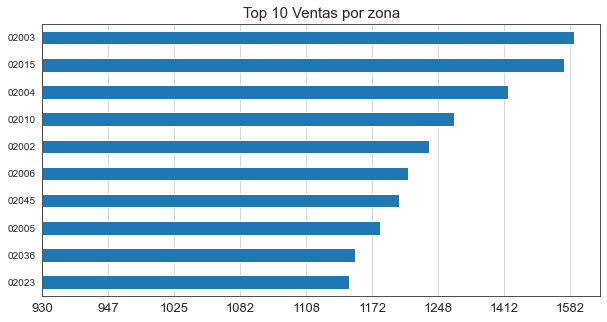

In [44]:
ax = pc.head(10).sort_values().plot(
    kind='barh',
    figsize = (10,5)
)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Top 10 Ventas por zona',fontsize=15)
ax.set_xticklabels(pc.head(10).sort_values().values, rotation='horizontal', fontsize=13)

ax.xaxis.grid()
plt.show()

In [45]:
pc.head(10).sort_values()

user_postal_code
02023     930
02036     947
02005    1025
02045    1082
02006    1108
02002    1172
02010    1248
02004    1412
02015    1582
02003    1611
Name: total_price, dtype: int64

# ¿Quién? (Mejores/peores shoppers, ...)

Busquemos los shopers que más facturan

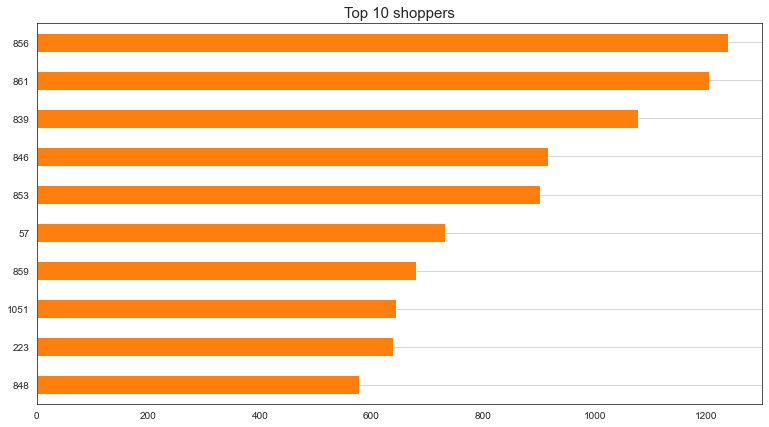

In [46]:
top_shoppers = delv_df.groupby('shopper_id')['total_price'].count().sort_values(ascending=False).head(10).sort_values()
ax = top_shoppers.plot(
    kind = 'barh',
    color = 'tab:orange',
    figsize = (13, 7)
)
ax.set_title('Top 10 shoppers', fontsize=15)
ax.set_ylabel('', fontsize=15)
ax.set_xlabel('', fontsize=15)
ax.yaxis.grid()
plt.show()

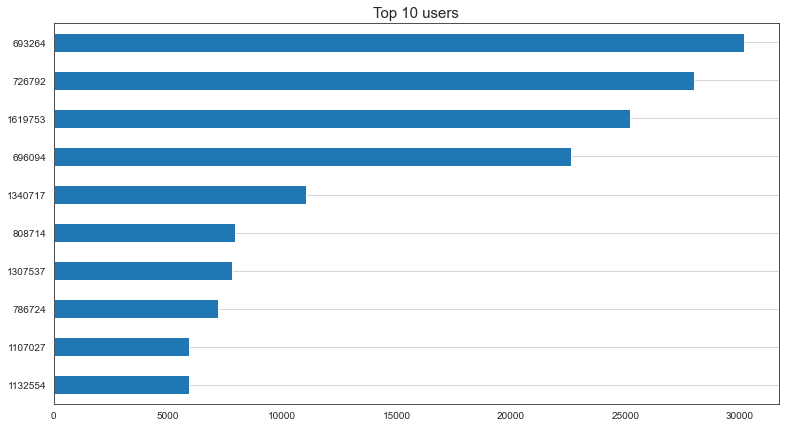

In [47]:
top_users = delv_df.groupby('user_id')['total_price'].sum().sort_values(ascending=False).head(10).sort_values()
ax = top_users.plot(
    kind = 'barh',
    figsize = (13, 7)
)
ax.set_title('Top 10 users', fontsize=15)
ax.set_ylabel('', fontsize=15)
ax.yaxis.grid()
plt.show()

Peores Shoppers

In [48]:
bad_shoppers = delv_df.groupby('shopper_id')['total_price'].count().sort_values(ascending=True).head(10)
bad_shoppers

shopper_id
1204    1
796     1
1214    1
1224    1
1293    1
1302    1
1305    1
1311    1
1312    1
1322    1
Name: total_price, dtype: int64

Busquemos la relación entre shoppers recurrentes y los nuevos.

In [49]:
shoppers = delv_df.groupby('shopper_id')['total_price'].count().sort_values()

shoppers_new = (shoppers == 1).sum()
shoppers_rec = shoppers.shape[0] - shoppers_new

In [50]:
shoppers_new_perc = ((shoppers_new / shoppers.shape[0])*100).round(0)
shoppers_rec_perc = ((shoppers_rec / shoppers.shape[0])*100).round(0)

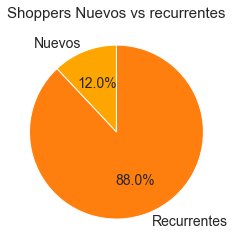

In [51]:
plt.pie(
    x=(shoppers_new_perc, shoppers_rec_perc),
    autopct = '%1.1f%%',
    startangle = 90,
    labels=['Nuevos', 'Recurrentes'],
    textprops={'fontsize': 14},
    colors=['orange','tab:orange'],
)
plt.title('Shoppers Nuevos vs recurrentes', fontsize=15)
plt.show()

Relación entre usuarios y shoppers

In [52]:
uniq_shoppers = shop_df.groupby(shop_df['request_delivered_at'].dt.month)['shopper_id'].nunique()
uniq_shoppers

request_delivered_at
1     107
2     123
3     135
4     149
5     151
6     165
7     140
8     182
9     185
10    179
11    175
12    153
Name: shopper_id, dtype: int64

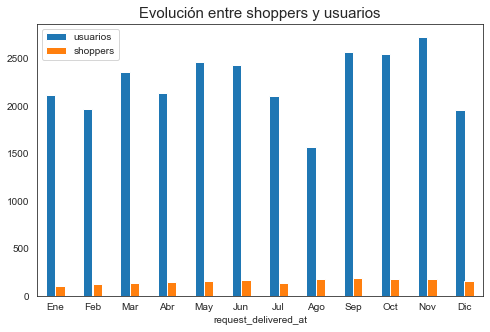

In [53]:
shop_use = pd.DataFrame({'usuarios': uniq_users, 'shoppers': uniq_shoppers})

ax = shop_use.plot(
    kind='bar',
    figsize = (8,5),
)

ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation='horizontal')
ax.set_title('Evolución entre shoppers y usuarios', fontsize=15)


plt.show()